In [0]:
infile_name = "20190911_8genre_288video_text"

# mecabインストール
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab

# mecab-ipadic-NEologdのダウンロード
!git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
!echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n

# 1.sedコマンドを使て、ファイルを変更、ファイル名を「mecabrc.new」として保存する。
!sed -e "s!/var/lib/mecab/dic/debian!/usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd!g" /etc/mecabrc > /etc/mecabrc.new

# 4.「mecabrc」のバックアップの保存（mecabrc.orgとする）
# 3.「mecabrc.new」を「mecabrc」に上書き

!cp /etc/mecabrc /etc/mecabrc.org
!cp /etc/mecabrc.new /etc/mecabrc

!pip install mecab-python3
!pip install japanize_matplotlib

-----------

## 共有ドライブのマウント
- 参考：https://qiita.com/kikuchi_kentaro/items/65be0cf40ac61849d841

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# URLを開いて認証コードをコピーしボックスに貼り付けしてください
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!cp -f ~/.gdfuse/default/config config
# text2metaフォルダをマウント
!sed -i -e "s/^root_folder=$/root_folder=1Dm6GSlI06zTsmRg6KdpM2WBYU0wj-Umh/" config

!mkdir -p drive
!google-drive-ocamlfuse -config ./config -cc drive

import os
# ユーザー辞書のコンパイル
os.chdir('drive/input/user_dic/')
!/usr/lib/mecab/mecab-dict-index -d /usr/share/mecab/dic/ipadic/ -u user.dic -f utf-8 -t utf-8 user.csv
!cp -p user.* /usr/share/mecab/dic/ipadic/

#「mecabrc」の中身を入れ替え
!cp mecabrc.usr /etc/mecabrc
!cat /etc/mecabrc

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 132902 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.13-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.13-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
import MeCab

import re
import csv
import datetime
import contextlib
import functools

import numpy as np
import pandas as pd
import urllib.request

import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
sns.set(font='IPAexGothic')

from IPython.display import display, Image
import warnings
warnings.filterwarnings('ignore')
os.chdir("../../../")

In [0]:
df = pd.read_csv(
    f'drive/input/raw_text/{infile_name}.csv',
#    encoding='shift_jisx0213',
    index_col=0
)

array(['01_news', '02_sport', '03_jyoho_wideshow', '04_drama',
       '06_variety', '08_anime_tokusatu', '09_documentary',
       '11_shumi_kyoiku'], dtype=object)

In [0]:
df = df.dropna().reset_index(drop=True)

In [0]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['genre_name'] = le.fit_transform(df['genre_name'])

In [0]:
mecab= MeCab.Tagger('-Ochasen -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -u /usr/share/mecab/dic/ipadic/user.dic')
#説明変数を'text_list'、目的変数を'label_list'にリストとして格納
label_list = df['genre_name'].values.tolist()
text_list = df['content'].values.tolist()

text_list = [re.sub(r'[!-/:-@[-`{-~]', ' ', re.sub(u'[■-♯・、。°δ①②③④⑤⑥⑦⑧⑨⑩⑪⑫⑬⑭⑮⑯⑰⑱⑲⑳【】《》σ×θΘ“↓→↑←『「」』≦≧≠≒＊※μµφΦ]', ' ', tx)) for tx in text_list]

In [0]:
parts_of_speech = [
                      'その他',
                      'フィラー',
                      '副詞',
                      '助動詞',
                      '助詞',
                      '動詞',
                      '名詞',
                      '形容詞',
                      '感動詞',
                      '接続詞',
                      '接頭詞',
                      '記号',
                      '連体詞'
                    ]
words = []
for i, ps in enumerate(parts_of_speech):
  word_ps = [[] for _ in text_list]
  for j, doc in enumerate(text_list):
    node = mecab.parseToNode(doc)
    while node:
      if ps == node.feature.split(',')[0] and not node.feature.split(',')[-3] in stop_words:
      # if ps == node.feature.split(',')[0]:
        word_ps[j].append(node.feature.split(',')[-3])
      node = node.next
  words.append(word_ps)
np.savez(f"drive/midway/{infile_name}_words_lemmatized_without_stop_words", 
                      その他=words[0],
                      フィラー=words[1],
                      副詞=words[2],
                      助動詞=words[3],
                      助詞=words[4],
                      動詞=words[5],
                      名詞=words[6],
                      形容詞=words[7],
                      感動詞=words[8],
                      接続詞=words[9],
                      接頭詞=words[10],
                      記号=words[11],
                      連体詞=words[12]
         )

In [0]:
df['genre_name'].to_csv(f'drive/midway/{infile_name}_labels.csv', index=None)

In [0]:
# 文字コードをshift_jisx0213に指定してcsvに保存
# shift_jisx0213' codec can't encode character *** というエラーが出るので"errors='ignore'"で指定
#with open("dataset/processed/words.csv", "w", encoding="shift_jisx0213",errors='ignore') as f: 
with open(f"drive/midway/{infile_name}_words_lemmatized.csv", "w", errors='ignore') as f: 
    # writerオブジェクトの作成 改行記号で行を区切る
    writer = csv.writer(f, lineterminator="\n")
    # csvファイルに書き込み
    writer.writerows(words)

In [0]:
import numpy as np
ps_counts = np.zeros((len(text_list), len(parts_of_speech))).astype(np.float)
mecab_wakati = MeCab.Tagger('-Owakati -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -u /usr/share/mecab/dic/ipadic/user.dic')
mecab_chasen = MeCab.Tagger('-Ochasen -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd -u /usr/share/mecab/dic/ipadic/user.dic')

for i, doc in enumerate(text_list):
  doc_size = len(mecab_wakati.parse(doc).split())
  for j, ps in enumerate(parts_of_speech):
    node = mecab_chasen.parseToNode(doc)
    while node:
      if node.feature.split(',')[0]==ps and not node.feature.split(',')[-3] in stop_words:
        ps_counts[i][j] += 1
      node = node.next
    ps_counts[i][j] /= (doc_size-cnt)

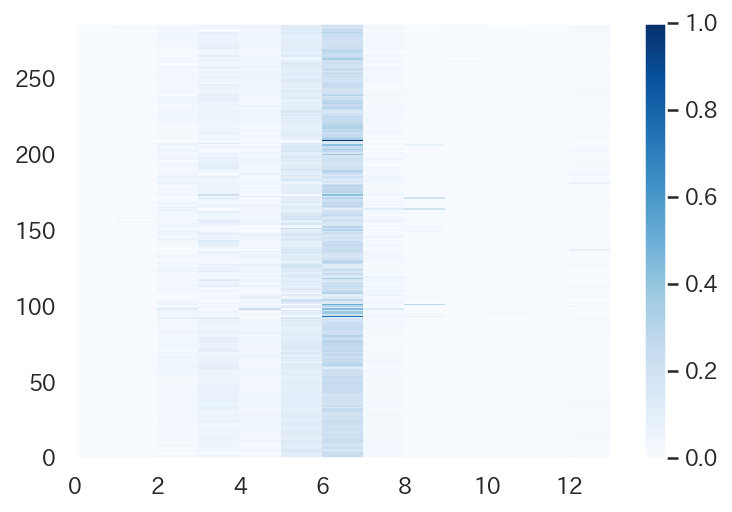

In [0]:
plt.pcolor(ps_counts, cmap=plt.cm.Blues)
plt.colorbar()

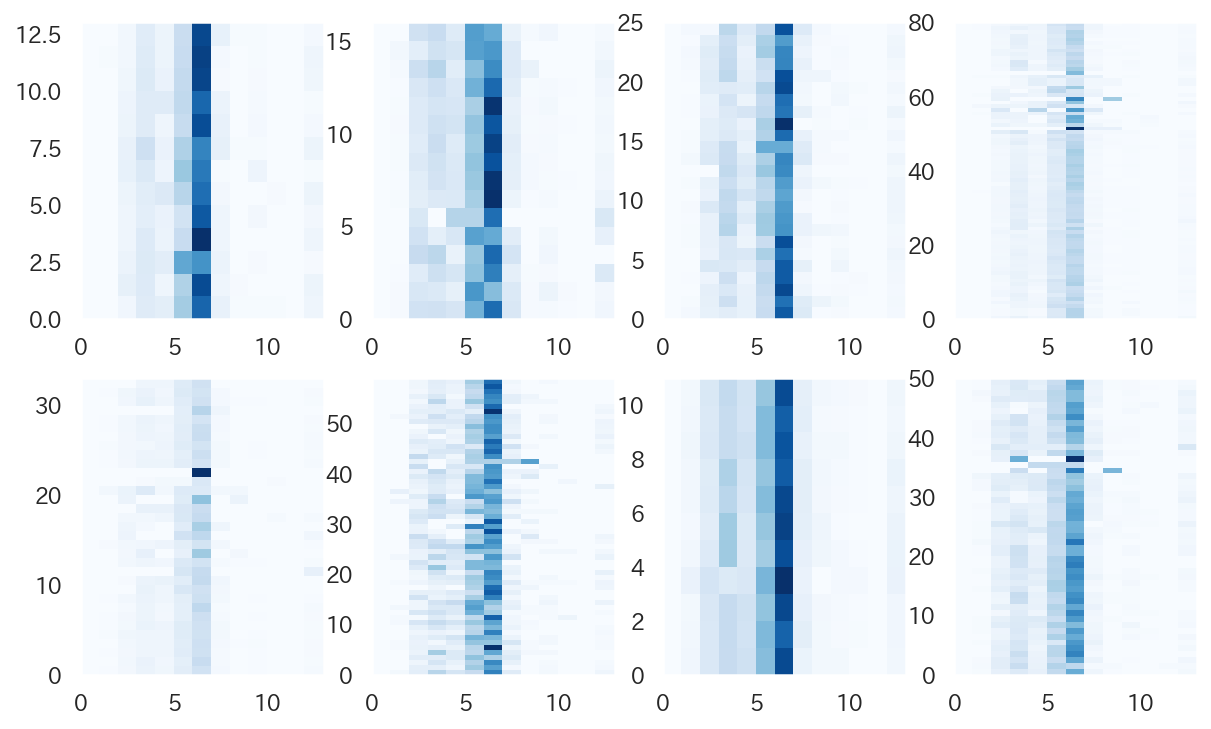

In [0]:
# ジャンルごとの品詞の割合をヒートマップで表しています
labels = df['genre_name'].values
fig = plt.figure(figsize=(10, 6))
for label in np.unique(labels):
  ax = fig.add_subplot(2, 4, label+1)
  pc = ps_counts[labels==label]
  ax.pcolor(pc, cmap=plt.cm.Blues)

In [0]:
ps_counts.sum(axis=1).mean()

0.5057306304873557

In [0]:
ps_counts[1]

array([0.        , 0.        , 0.02806122, 0.05357143, 0.0255102 ,
       0.10969388, 0.22959184, 0.0255102 , 0.00255102, 0.00255102,
       0.00255102, 0.        , 0.01785714])